# Importing libraries and cleaned dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Disabling a specific type of warning from Jupyter, that I know if mistaken for something else
pd.options.mode.chained_assignment = None 

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [4]:
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# EDA

The main points from the below analysis are:
- majority of Clients in UK (ca. 90%) -> I am gonna focus my analysis and forecasts on those clients
- there are many outliers and no normal distribution for the Order values, quantities etc. That suggests to me that there probably are two main groups (wholesale customers and normal customers), and they have fundamentally different ordering behavious. I will try to cluster these two groups, and then build for each one of them a model for forecasts.
- for the time series analysis, I see that I have many outliers and because the data are from 1 year, I cannot see clearly the seasonality. Since, until I have more data for more months/years, I cannot work with a ML model that takes seasonality, I will focus on other models. Before doing that I will try to deal with the outliers (through client clustering), and then I will start building a ML model.

In [6]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df = df[df.StockCode != 'OTHER']

In [7]:
# Total number of clients
df.CustomerID.nunique()

4335

## Majority of clients and orders are from UK

In [8]:
# Countries with the highest count of (distinct) invoices
df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

Country
United Kingdom          17912
Germany                   443
France                    382
Ireland                   282
Belgium                    98
Netherlands                93
Spain                      88
Australia                  56
Switzerland                50
Portugal                   50
Finland                    40
Italy                      35
Sweden                     34
Norway                     32
Channel Islands            25
Japan                      19
Poland                     19
Denmark                    18
Austria                    17
Cyprus                     14
Unspecified                13
Israel                      8
Iceland                     7
Hong Kong                   7
USA                         5
Malta                       5
Canada                      5
Greece                      5
Lithuania                   4
Singapore                   4
European Community          3
Bahrain                     3
Czech Republic              2
Un

In [73]:
# Countries with the highest count of (distinct) invoices, percentage
((df.groupby('Country')['InvoiceNo'].nunique() / df['InvoiceNo'].nunique()) * 100).sort_values(ascending=False).head()

Country
United Kingdom    90.537808
Germany            2.239183
France             1.930853
Ireland            1.425394
Belgium            0.495350
Name: InvoiceNo, dtype: float64

In [23]:
# Countried with the highest sum or order value
df.groupby('Country')['UnitPrice'].sum().round(2).sort_values(ascending=False).head()

Country
United Kingdom    1340421.95
Ireland             26850.75
Germany             24044.29
France              21741.24
Spain                7798.75
Name: UnitPrice, dtype: float64

In [24]:
# Countried with the highest count of (distinct) clients
df.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False).head()

Country
United Kingdom    3917
Germany             94
France              87
Spain               30
Belgium             25
Name: CustomerID, dtype: int64

## Total orders value

In [11]:
# Calculating item-wise total price 
df['TotalValue'] = df.Quantity * df.UnitPrice

In [12]:
# New dataframe per order
orders = df.groupby('InvoiceNo')['Quantity'].sum().reset_index()
orders = pd.merge(orders, df.groupby('InvoiceNo')['TotalValue'].sum().reset_index()[['InvoiceNo','TotalValue']], how='left', on='InvoiceNo')
orders

,InvoiceNo,Quantity,TotalValue
0,536365,40,168.10
1,536366,12,23.70
2,536367,83,289.81
3,536368,15,70.05
4,536369,3,17.85
...,...,...,...
19779,581583,76,141.60
19780,581584,120,128.88
19781,581585,278,336.49
19782,581586,66,427.90


<Axes: xlabel='TotalValue', ylabel='Count'>

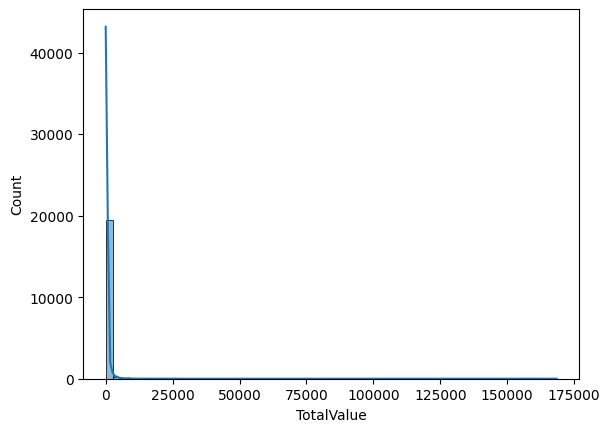

In [13]:
sns.histplot(orders['TotalValue'], kde=True, bins=60)

In [20]:
# I am removing the two main outliers I have spotted in 01_InitialExploration and
# with the diagram below it looks a bit better
orders_fltrd = orders[~orders.InvoiceNo.isin(['581483','541431'])]
orders_fltrd

,InvoiceNo,Quantity,TotalValue
0,536365,40,168.10
1,536366,12,23.70
2,536367,83,289.81
3,536368,15,70.05
4,536369,3,17.85
...,...,...,...
19779,581583,76,141.60
19780,581584,120,128.88
19781,581585,278,336.49
19782,581586,66,427.90


<Axes: xlabel='TotalValue', ylabel='Count'>

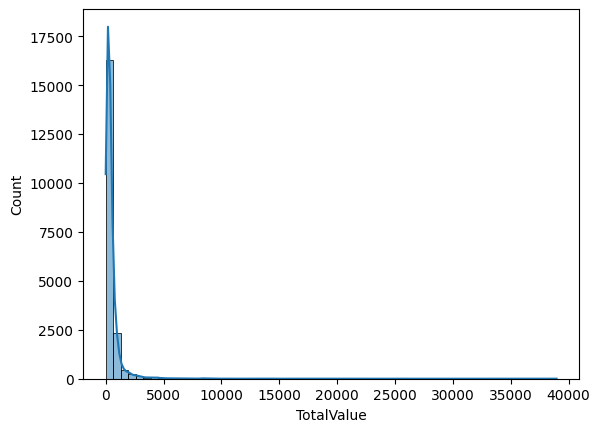

In [19]:
sns.histplot(orders_fltrd['TotalValue'], kde=True, bins=60)

<Axes: ylabel='TotalValue'>

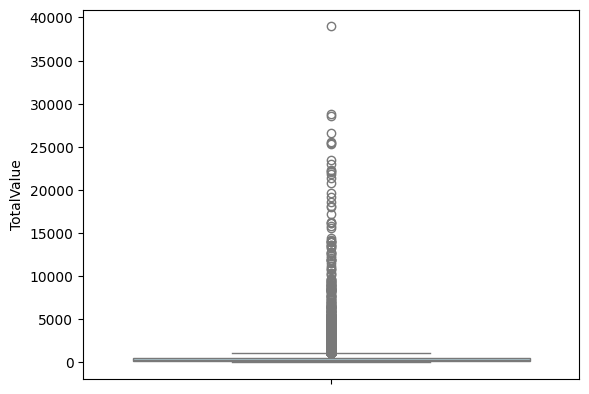

In [22]:
sns.boxplot(data = orders_fltrd['TotalValue'], color="lightblue") # there are many outliers

## Average order quantity per client

In [26]:
orders_fltrd

,InvoiceNo,Quantity,TotalValue
0,536365,40,168.10
1,536366,12,23.70
2,536367,83,289.81
3,536368,15,70.05
4,536369,3,17.85
...,...,...,...
19779,581583,76,141.60
19780,581584,120,128.88
19781,581585,278,336.49
19782,581586,66,427.90


In [45]:
customers = df.dropna(subset='CustomerID')
customers = customers[~customers.InvoiceNo.isin(['581483','541431'])]

In [46]:
# Mean quantity per order
customers = customers.groupby(['CustomerID','InvoiceNo'])['Quantity'].mean().reset_index()
customers = customers.groupby('CustomerID')['Quantity'].mean().sort_values(ascending=True).reset_index()
customers

,CustomerID,Quantity
0,12789,1.0
1,16257,1.0
2,14792,1.0
3,13452,1.0
4,16349,1.0
...,...,...
4329,14609,1756.5
4330,16308,2000.0
4331,16754,2140.0
4332,18087,3906.0


In [49]:
customers.Quantity.describe()

count    4334.000000
mean       24.063085
std       122.315718
min         1.000000
25%         6.233636
50%        10.188737
75%        15.395834
max      4300.000000
Name: Quantity, dtype: float64

In [56]:
# Mean quantity per order
cust_order_sum = df.dropna(subset='CustomerID')
cust_order_sum = cust_order_sum[~cust_order_sum.InvoiceNo.isin(['581483','541431'])]

cust_order_sum = cust_order_sum.groupby(['CustomerID','InvoiceNo'])['Quantity'].sum().reset_index()
cust_order_sum = cust_order_sum.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=True).reset_index()
cust_order_sum

,CustomerID,Quantity
0,17956,1
1,15823,1
2,16257,1
3,16454,2
4,17102,2
...,...,...
4329,17511,64549
4330,17450,69973
4331,12415,77373
4332,14911,80154


In [62]:
customers.quantile(0.95)

CustomerID     17984.35
Quantity      57.685268
Name: 0.95, dtype: Float64

In [52]:
cust_list_95 = customers[customers.Quantity < 57.0].CustomerID.tolist()
cust_list_05 = customers[customers.Quantity >= 57.0].CustomerID.tolist()
#test_q.quantile(0.97).Quantity
print(len(cust_list_95))
print(len(cust_list_05))

4112
222


In [63]:
cust_order_sum[cust_order_sum.CustomerID.isin(cust_list_95)].Quantity.sum()

3476992

In [65]:
cust_order_sum[~cust_order_sum.CustomerID.isin(cust_list_95)].Quantity.sum()

1509597

Conclusions:

From the above I see that there is value in seperating the customers in wholesale/ retail, cause I see that 95% of the customer have 57 in mean Quantity, and 5% above. And that 95% only has approximately double the Quantity number and Total Price in comparison with the 5% group!
That shows that there seems to be two main cluster of clients, that also have quite different ordering behaviour, the retail ones and the wholesale ones.

<Axes: xlabel='Quantity', ylabel='Count'>

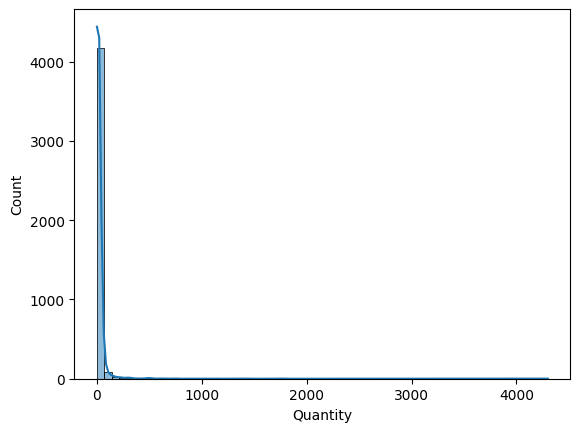

In [47]:
sns.histplot(customers['Quantity'], kde=True, bins=60)

<Axes: ylabel='Quantity'>

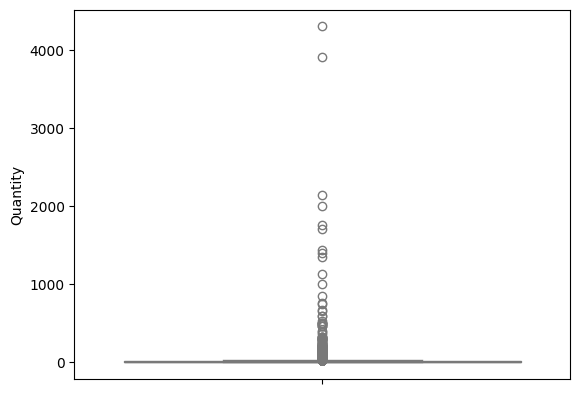

In [48]:
sns.boxplot(data = customers['Quantity'], color="lightblue")

## Products quantity sold over time

<Axes: xlabel='InvoiceDate'>

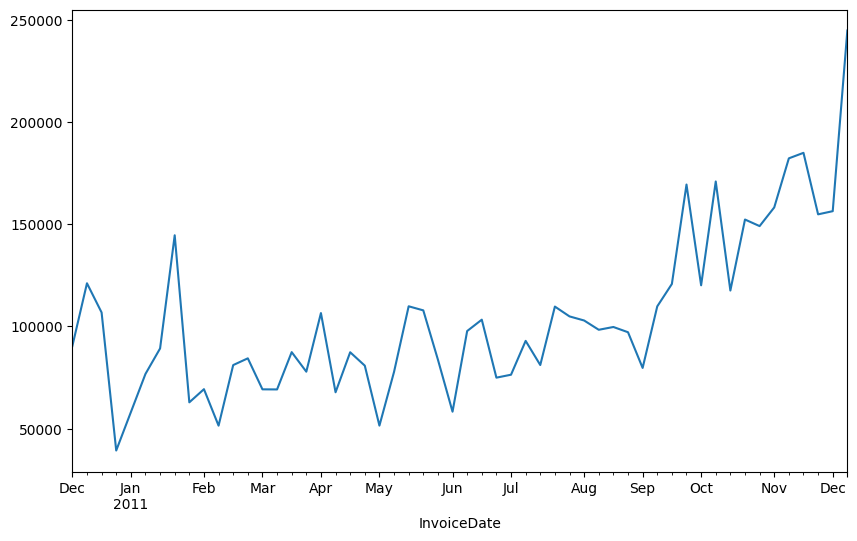

In [68]:
# per week
df.groupby(df['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(figsize=(10, 6))

<Axes: xlabel='InvoiceDate'>

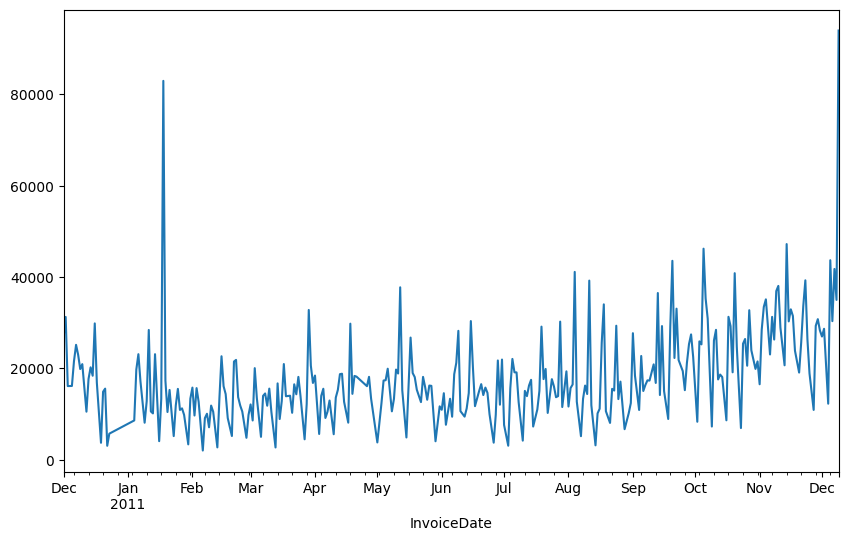

In [69]:
# per day
df.groupby(df['InvoiceDate'].dt.to_period('D'))['Quantity'].sum().plot(figsize=(10, 6))

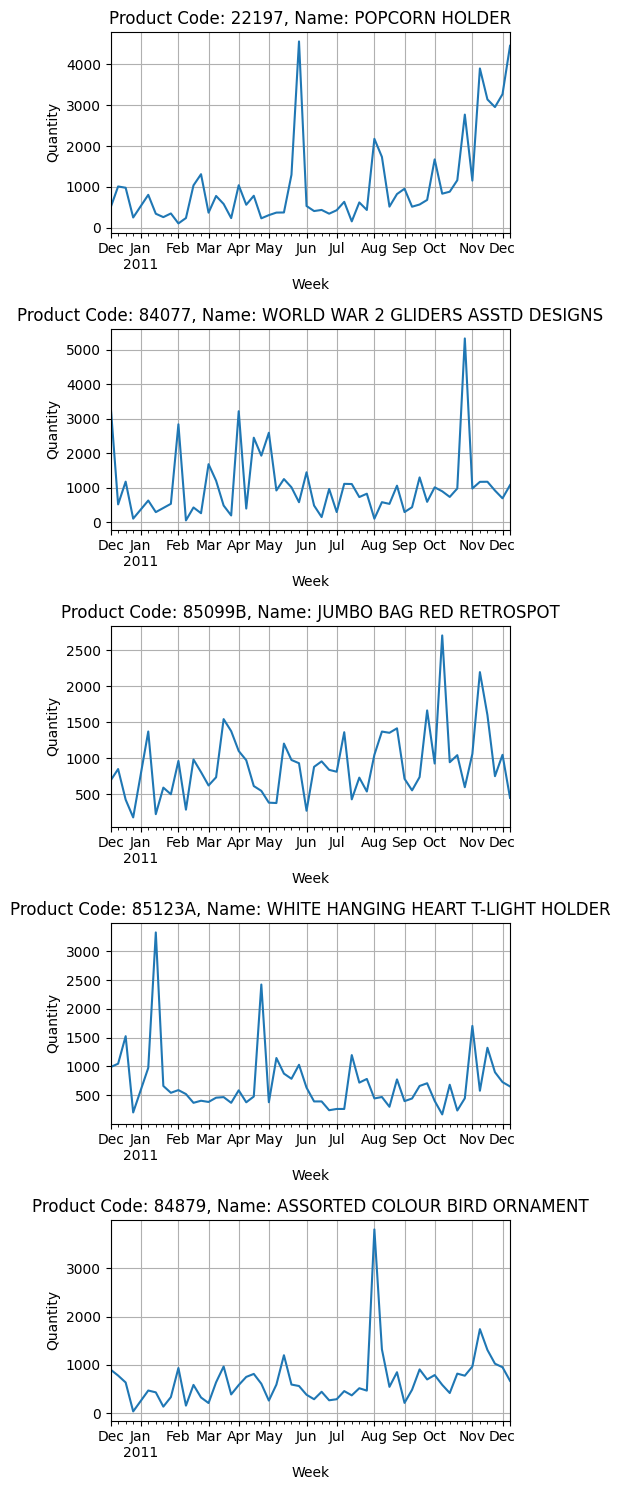

In [71]:
# List of product codes to plot
product_codes = ['22197','84077','85099B','85123A','84879' ]

# Create subplots
fig, axes = plt.subplots(len(product_codes), 1, figsize=(5, 3 * len(product_codes)))

# Iterate over each product code
for i, code in enumerate(product_codes):
    # Filter DataFrame for the current product code
    df_product = df[df['StockCode'] == code]
    
    # Group by week and calculate total sales, plot total sales per (week/day) for the current product code
    ax = df_product.groupby(df_product['InvoiceDate'].dt.to_period('W'))['Quantity'].sum().plot(ax=axes[i])
    #ax = df_product.groupby(df_product['InvoiceDate_noTime'])['TotalPrice'].sum().plot(ax=axes[i])
    ax.set_title(f"Product Code: {code}, Name: {df[df['StockCode'] == code].Description.mode()[0]}")
    ax.set_ylabel("Quantity")
    ax.set_xlabel("Week")
    ax.grid(True)

# Adjust layout and spacing
plt.tight_layout()
plt.show()